In [1]:
import tensorflow as tf

In [2]:
file = 'data/donkey_20200921_114808.tfrec'
dataset = tf.data.TFRecordDataset(file)

In [3]:
feature_description = {
    'stearing': tf.io.FixedLenFeature([], tf.float32, default_value=0.5),
    'throttle': tf.io.FixedLenFeature([], tf.float32, default_value=0.0),
    'image': tf.io.FixedLenFeature([], tf.string, default_value='')
}
def _parse_function(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_description)

def _get_images(example_proto):
    parsed_row = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(parsed_row['image'], channels=3)
    parsed_row['image'] = tf.cast(image, dtype=tf.float32)
    indice = tf.cast(parsed_row['stearing'] * (9 - 1), tf.uint8)
    parsed_row['stearing'] = tf.one_hot(indice, 9)
    return parsed_row

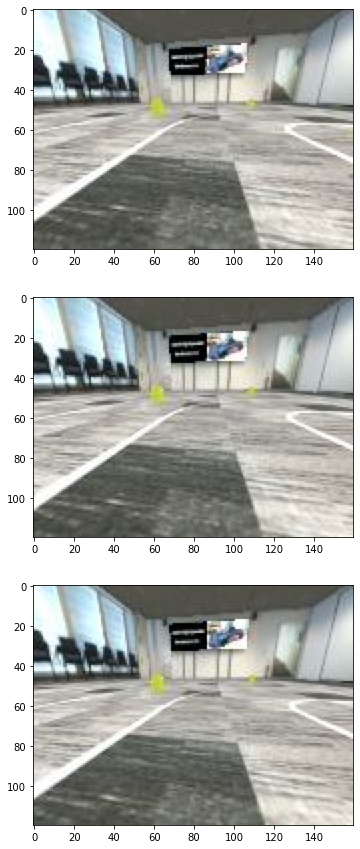

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))
for i, row in enumerate(dataset.map(_get_images).skip(160).take(3)):
    im = tf.keras.preprocessing.image.array_to_img(row['image'])
    s = row['stearing']
    plt.subplot(3, 1, i+1)
    plt.imshow(im)

In [7]:
def tf_equalizeHist(tf_image):
    histo = tf.histogram_fixed_width(tf_image, [0, 255], nbins=256)
    cs = tf.cumsum(histo)
    nj = (cs - tf.reduce_min(cs)) * 255
    N = tf.reduce_max(cs) - tf.reduce_min(cs)
    cs = nj // N
    tf_image = tf.gather(cs, tf_image)
    return tf.cast(tf_image, tf.uint8)

In [10]:
import tensorflow_addons as tfa

In [52]:
def transform_to_sobel(image, top, bottom, size_x, size_y):
    
    tf_image = tf.image.crop_to_bounding_box(image, top, bottom, size_x, size_y)
    tf_image = tf.cast(tf_image, tf.float32)
    tf_image = tf_image / 255.0
    tf_image = tfa.image.equalize(tf_image)
    tf_image = tf.image.rgb_to_grayscale(tf_image)
    tf_image = tfa.image.mean_filter2d(tf_image, filter_shape=3)
    #tf_image = tf.image.convert_image_dtype(tf_image,tf.uint8)
    #tf_image = tf.expand_dims(tf_image, 0)
    #tf_image = tfa.image.euclidean_dist_transform(tf_image)
    #tf_image = tf.squeeze(tf_image, (0, -1))
    return tf.image.sobel_edges(tf_image[tf.newaxis,...])

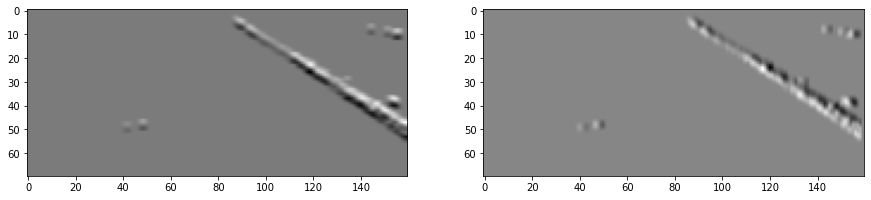

In [151]:
plt.figure(figsize=(15, 15))
for i, row in enumerate(dataset.map(_get_images).skip(560).take(1)):
    tf_image = transform_to_sobel(row['image'],50,0,70,160)
    im = tf.keras.preprocessing.image.array_to_img(tf_image[0,...,0])
    im2 = tf.keras.preprocessing.image.array_to_img(tf_image[0,...,1])
    plt.subplot(3, 2, ((i+1)*2)-1)
    plt.imshow(im, 'gray')
    plt.subplot(3, 2, ((i+1)*2))
    plt.imshow(im2, 'gray')

In [165]:
tf.reduce_min(tf_image)

<tf.Tensor: shape=(), dtype=float32, numpy=-443.6462>

In [152]:
import cv2
import numpy as np
def normalize_tensor(tensor):
    return (tensor -  np.amin(tensor)) /  (np.amax(tensor) - np.amin(tensor))

def transform_to_sobel_cv(image, top, bottom, size_x, size_y):
    
    tf_image = image[50:120,...].numpy()
    tf_image = tf_image / 255.0
    tf_image = cv2.cvtColor(tf_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    tf_image = cv2.equalizeHist(tf_image)
    
    tf_image = cv2.GaussianBlur(tf_image, (3, 3), 0)
    sobelx = cv2.Sobel(tf_image,cv2.CV_64F,1,0,ksize=5)
    sobely = cv2.Sobel(tf_image,cv2.CV_64F,0,1,ksize=5)
    return (normalize_tensor(sobelx), normalize_tensor(sobely))

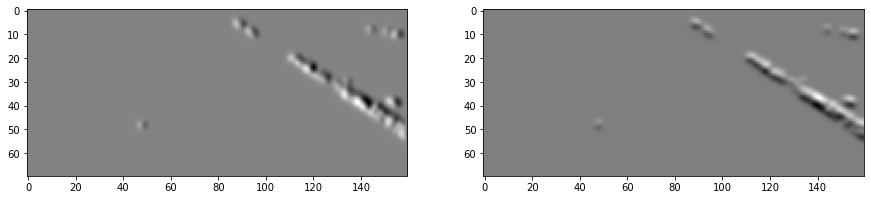

In [153]:
plt.figure(figsize=(15, 15))
for i, row in enumerate(dataset.map(_get_images).skip(160).take(1)):
    im = transform_to_sobel(row['image'],50,0,70,160)
    plt.subplot(3, 2, ((i+1)*2)-1)
    plt.imshow(im[0], 'gray')
    plt.subplot(3, 2, ((i+1)*2))
    plt.imshow(im[1], 'gray')

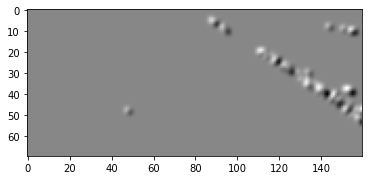

In [154]:
image = im[0] + im[1]
plt.imshow(image, 'gray')